In [63]:
import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
import torchaudio
from torchaudio.models import WaveRNN
from IPython.display import Audio

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt    
import os
import random
from tqdm import tqdm 

In [4]:
waveform, sample_rate = torchaudio.load(crema_d_spec_path)
print(waveform.size(), sample_rate)

torch.Size([1, 36409]) 16000


In [5]:
#calculation
mw = 0
ms = 0
max_waveform_length = 80080
directory = './AudioWAV'
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        
        filepath = os.path.join(directory, filename)
        
        
        # Load audio waveform
        waveform, sr = torchaudio.load(filepath)

        waveform_length = waveform.size(1)
        if waveform_length < max_waveform_length:
            padding = torch.zeros(1, max_waveform_length - waveform_length)
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform_length > max_waveform_length:
            waveform = waveform[:, :max_waveform_length]
        
        # Compute spectrogram
        mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80, n_fft=400, hop_length=162)
        spectrogram = mel_spec_transform(waveform)

        mw = max(mw, waveform.size(1))
        ms = max(ms, spectrogram.size(2))

print(mw)
print(ms)


            
            

80080
495


In [43]:
def load_dataset(directory, max_waveform_length, max_spec_len):
    dataset = []
    raw_dataset = []
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            emotion = filename.split('_')[2]
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            raw_dataset.append([filepath, emotion_label])
            
            # Load audio waveform
            waveform, sr = torchaudio.load(filepath)
            
            waveform_length = waveform.size(1)
            if waveform_length < max_waveform_length:
                padding = torch.zeros(1, max_waveform_length - waveform_length)
                waveform = torch.cat([waveform, padding], dim=1)
            elif waveform_length > max_waveform_length:
                waveform = waveform[:, :max_waveform_length]
            
            # Compute spectrogram
            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80, n_fft=400, hop_length=162)
            spectrogram = mel_spec_transform(waveform)
            
            # Pad or truncate spectrogram to max_spec_len
            spec_len = spectrogram.size(2)
            if spec_len < max_spec_len:
                padding = torch.zeros(1, 80, max_spec_len - spec_len)  # Add a new axis
                spectrogram = torch.cat([spectrogram, padding], dim=2)

            elif spec_len > max_spec_len:
                spectrogram = spectrogram[:, :, :max_spec_len]
            
            # Convert raw signal to decibels
            epsilon = 1e-10
            spec_db = 10 * torch.log10(spectrogram + epsilon)
            
            dataset.append((spec_db, emotion_label))

    return dataset, raw_dataset

def split_dataset(dataset, batch_size, train_ratio=0.8):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [44]:
crema_d_path = './AudioWAV'
dataset, raw_dataset = load_dataset(crema_d_path, 80080, 500)
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 32)

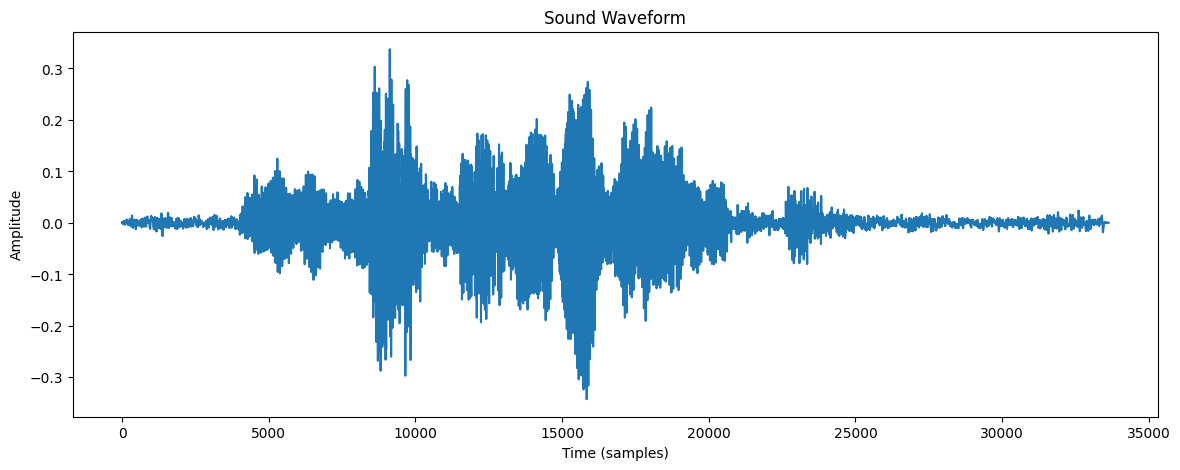

In [66]:
#Visualising the data
ex_audio, ex_label = raw_dataset[random.randint(0,len(raw_dataset))]
y, sr = librosa.load(ex_audio, sr=None)

#Visualize sound wave
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Sound Waveform')
plt.show()

Audio(data=y, rate=sr)


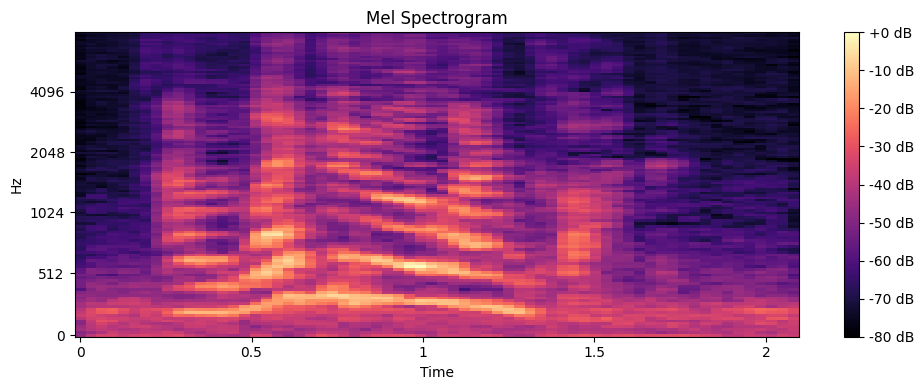

In [67]:
# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [57]:
print(len(dataset))
for batch_idx, (s, l) in enumerate(train_dataloader):
    print(s.size())
    print(l.size())
    break


7442
torch.Size([32, 1, 80, 500])
torch.Size([32, 6])


In [33]:
class RNN(nn.Module):
   def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.4)
      self.fc1 = nn.Linear(hidden_size, int(hidden_size/2))
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(int(hidden_size/2), int(hidden_size/2))
      self.fc3 = nn.Linear(int(hidden_size/2), num_classes)
      self.softmax = nn.Softmax(dim=1)  # Add softmax layer
   
   def forward(self, x):
      # Flatten the spectrogram data along the frequency_bins dimension
      x = x.view(x.size(0), -1, x.size(3))  # [batch_size, channels * frequency_bins, time_steps]
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
      out, _ = self.lstm(x, (h0, c0))  
      # Only take the output from the last time step
      out = self.relu(self.fc1(out[:, -1, :])) # [batch_size, num_classes]
      out = self.relu(self.fc2(out))
      out = self.fc3(out)
      out = self.softmax(out)  # Apply softmax activation
      return out

In [18]:
#training step - 1 epoch
# specgram = specgram.view(specgram.size(0), specgram.size(1), -1)
def train_step(model, loss_function, optimizer, train_dataloader):

    losses = []
    for i, (specgram, label) in enumerate(tqdm(iter(train_dataloader))):
        
        optimizer.zero_grad()
        pred = model(specgram)
        loss = loss_function(pred, label) #err incompatible tensoor dimensions
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return losses

In [34]:
batch_size = 128
lr = 1e-4

input_size = 500  # input size after flattening the spectrogram
hidden_size = 100  # size of the hidden state
num_layers = 4  # number of LSTM layers
num_classes = 6  # number of output classes

train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, batch_size)

# Initialize the LSTM model
model = RNN(input_size, hidden_size, num_layers, num_classes)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [35]:
def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    # model.train()
    losses = []

    for n in range(n_epochs):
        for i, (specgram, label) in enumerate(tqdm(iter(train_dataloader))):
            
            optimizer.zero_grad()
            pred = model(specgram)
            loss = loss_function(pred, label) #err incompatible tensoor dimensions
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

100%|██████████| 47/47 [00:05<00:00,  8.15it/s]

avg loss: 1.6902027190006697


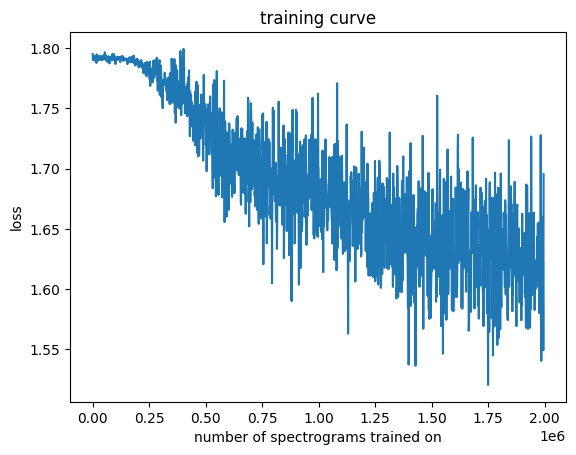

In [36]:
n_epochs=30
update_interval=10

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

print("avg loss:", sum(losses)/len(losses))

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of spectrograms trained on")
plt.ylabel("loss")
plt.show()

In [23]:
def test_accuracy(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (spec, label) in enumerate(tqdm(iter(test_data))):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part (and we record the accuracy too)
        pred = model(spec)
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        _, label = torch.max(label,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )
    #test

    return test_acc, avg_loss

In [37]:
# To see how well your model is doing without hyperpameter tuning

print("testing the previously trained model")
test_acc,avg_loss = test_accuracy(trained_model, loss_function, test_dataloader)

print("Testing accuracy of your first model:", test_acc)
print("Average loss of your first model:", avg_loss)

testing the previously trained model


100%|██████████| 12/12 [00:00<00:00, 13.70it/s]

test accuracy: 39.22
test loss: 1.63
Testing accuracy of your first model: 39.22
Average loss of your first model: 1.63
